## NOTE: all the algorithms should start with this code

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
houses = ['A', 'B', 'C']
xtype_dict = {'r':'raw', 'c':'change'}

In [3]:
def read_data(house, xtype):
    assert house in houses
    assert xtype in xtype_dict
    
    act_df = pd.read_csv("house{}_act.csv".format(house))
    sensor_df = pd.read_csv("house{}_sensor.csv".format(house))
    X = np.load("X_{}_house{}.npy".format(xtype_dict[xtype], house))
    Y = np.load("Y_house{}.npy".format(house))
    return act_df, sensor_df, X, Y

In [4]:
act_df,sensor_df,X,Y = read_data('A', 'r')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))

timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start

# Example

In [5]:
#read in data, choose a house and a X matrix type
act_df,sensor_df,X,Y = read_data('A', 'r')

# IMPORTANT: better run this to build index dicts

In [6]:
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))

In [7]:
a2i

{0: 16,
 1.0: 0,
 3.0: 1,
 4.0: 2,
 5.0: 3,
 6.0: 4,
 10.0: 5,
 13.0: 6,
 15.0: 7,
 16.0: 8,
 17.0: 9,
 18.0: 10,
 19.0: 11,
 20.0: 12,
 22.0: 13,
 23.0: 14,
 25.0: 15}

# Now you can start your own code..

In [8]:
#e.g. print something
print "# sensors: ", len(all_sensor)
print "# states/acts (including unknown): ", len(all_act)
print "# timeframes: ", len(X)

# sensors:  14
# states/acts (including unknown):  17
# timeframes:  40006


In [9]:
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start

In [10]:
print start,end

1203898772 1206299132


In [11]:
i2m = {}
for i in range(len(all_act)):
    
    i2m[i] = set(act_df[act_df['label']==i2a[i]]['meaning'])

In [12]:
i2m,a2i

({0: {'leave house'},
  1: {'Eating'},
  2: {'use toilet'},
  3: {'take shower'},
  4: {'brush teeth'},
  5: {'go to bed'},
  6: {'prepare Breakfast'},
  7: {'prepare Dinner'},
  8: {'get snack'},
  9: {'get drink'},
  10: {'put items in dishwasher'},
  11: {'unload dishwasher'},
  12: {'store groceries'},
  13: {'put clothes in washingmachine'},
  14: {'unload washingmachine'},
  15: {'receive guest'},
  16: set()},
 {0: 16,
  1.0: 0,
  3.0: 1,
  4.0: 2,
  5.0: 3,
  6.0: 4,
  10.0: 5,
  13.0: 6,
  15.0: 7,
  16.0: 8,
  17.0: 9,
  18.0: 10,
  19.0: 11,
  20.0: 12,
  22.0: 13,
  23.0: 14,
  25.0: 15})

# Prior A

In [13]:
#read in data, choose a house and a X matrix type
act_df,sensor_df,X,Y = read_data('A', 'r')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
#e.g. print something
print "# sensors: ", len(all_sensor)
print "# states/acts (including unknown): ", len(all_act)
print "# timeframes: ", len(X)
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
i2m = {}
for i in range(len(all_act)):
    
    i2m[i] = set(act_df[act_df['label']==i2a[i]]['meaning'])

# sensors:  14
# states/acts (including unknown):  17
# timeframes:  40006


In [16]:
num_t = len(X)
num_act = len(all_act)

HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1
LIKELY = 2
HIGHLY_LIKELY = 3
VERY_LIKELY = 4 
ALMOST_CERTAINLY = 8
# six_am of starting date of house A at Amsterdam
first_zero_am = 1203894000
first_six_am = 1203915600
first_time_dict = {}
for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}

priorA = np.zeros([num_t,num_act+1])
for i in range(priorA.shape[0]):
    priorA[i] = np.random.uniform(size=num_act+1)
random_priorA = priorA.copy()
print priorA[0]
#print priorA[0]
# add some prior to it
# leaving the house should be uniform between 8:00am to 10:00pm, and basically 0 between 10:00pm to 8:00am
first_leaving = (first_six_am + 2 * HOUR * MINUTE - start)/MINUTE
#print first_leaving
end_leaving = first_leaving + HOUR * (22-8)
for i in range(num_t):
    
    # leave house
    if i%DAY < first_time_dict[22] and i%DAY > first_time_dict[8]:
        priorA[i][0] += ALMOST_CERTAINLY
    # eating 6-9 am 12 -13 pm 18-19
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]) or (i%DAY > first_time_dict[12] and i%DAY < first_time_dict[13]) or (i%DAY > first_time_dict[18] and i%DAY < first_time_dict[19]):
        priorA[i][1] += LESS_LIKELY

    # use toilet should be uniform 2
    
    # Take shower should be within 6-8am and 21-23 3
    
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]) or (i%DAY > first_time_dict[21] and i%DAY < first_time_dict[23]):
        priorA[i][3] += LIKELY
    
    # brush teath is so short to modify 4
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[8]) or (i%DAY > first_time_dict[22] and i%DAY < first_time_dict[23]):
        priorA[i][4] += LIKELY
    # go to bed should between 11:00pm to 7:00 am 5
    if (i%DAY > first_time_dict[23] or i%DAY < first_time_dict[7]):
        priorA[i][5] += ALMOST_CERTAINLY
    
    # prepare Breakfast must be within 6-8am 6 
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]):
        priorA[i][6] += LIKELY
    
    # prepare Dinner must be within 5-7 pm 7
    if (i%DAY > first_time_dict[17] and i%DAY < first_time_dict[19]):
        priorA[i][7] += LIKELY
    
    # get snack is almost uniformly distributed within day time 8am-10pm 8
    if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[22]):
        priorA[i][8] += LESS_LIKELY
    
    # get drink is identical to get snack 9
    if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[22]):
        priorA[i][9] += LESS_LIKELY
        
    # 'put items in dishwasher' randomly among all day.10
    if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[20]):
        priorA[i][10] += LESS_LIKELY
    
    # unload dishwasher randomly from 10 am to 8 pm11
    if (i%DAY > first_time_dict[10] and i%DAY < first_time_dict[20]):
        priorA[i][11] += LESS_LIKELY
        
    # store greceries, randomly among all day from 10 am to 7pm 12
    if (i%DAY > first_time_dict[10] and i%DAY < first_time_dict[19]):
        priorA[i][12] += LESS_LIKELY
    
    # put clothes in washingmachine key no change 13 no change
    # unload washingmachine no change
    # receive guest randomly between 10 am to 5 pm: change15
    
    if (i%DAY > first_time_dict[10] and i%DAY < first_time_dict[17]):
        priorA[i][15] += LIKELY
    
    # Unknown state 16, almost certainly from 8am - 10pm:
    
    if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[23]):
        priorA[i][16] += ALMOST_CERTAINLY
        
    priorA[i]/=np.sum(priorA[i])
# Eating should be around 6-9 am, 12 - 1 pm, and 6-7 pm

# for i in range(num_t):
#     if i%DAY > first_time_dict[6] and i%DAY < first_time_dict[9] 
#     \ or i%DAY > first_time_dict[12] and i%DAY < first_time_dict[13] 
#     \ or i%DAY > first_time_dict[18] and i%DAY < first_time_dict[19]:
#         priorA[i][1] += 2


[ 0.33573485  0.95797433  0.45356734  0.9517873   0.30321973  0.13654675
  0.17988646  0.12833932  0.99582999  0.48746277  0.11965954  0.06964422
  0.24386952  0.44424475  0.4789913   0.78304117  0.76639148  0.99495053]


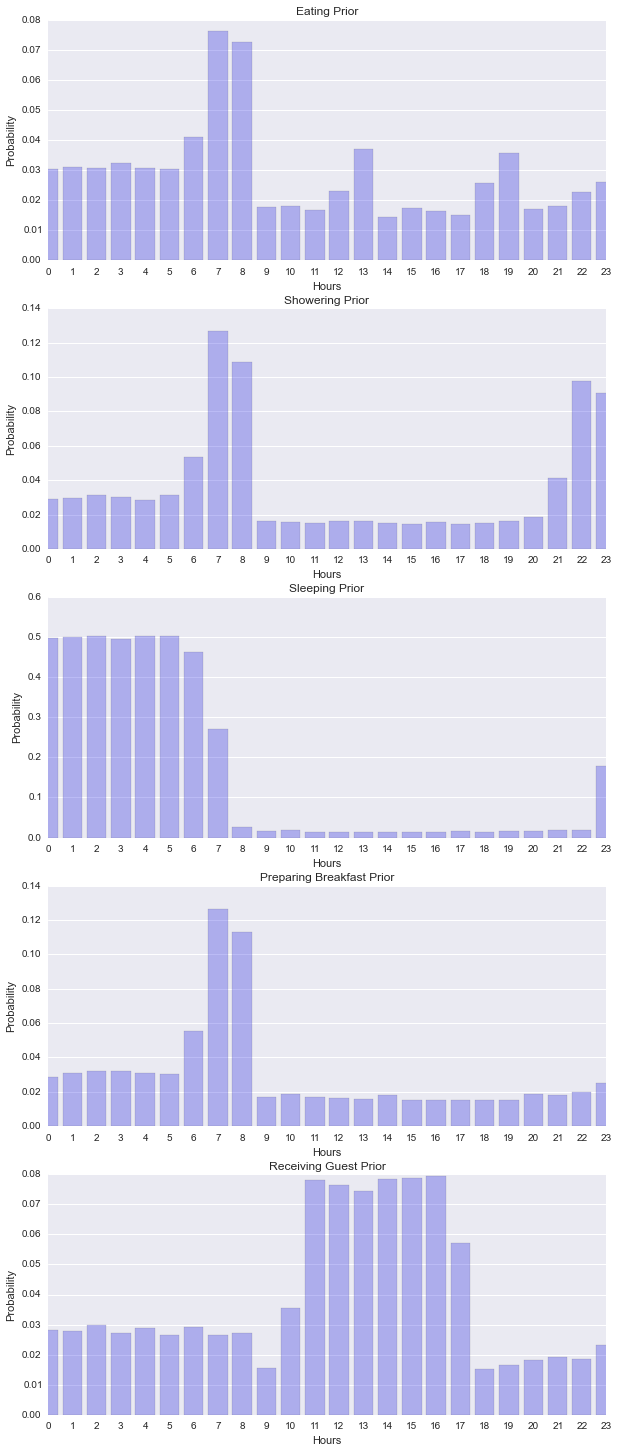

In [17]:
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
# Eating
#print ax[0]
day_eating = priorA[:,1][:MINUTE * 24].reshape(24,60)
day_hourly_eating = np.mean(day_eating,axis=1)
day_hourly_eating = np.roll(day_hourly_eating,2)
sns.barplot(day1,day_hourly_eating,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Eating Prior')

#take shower
day_showering = priorA[:,3][:MINUTE * 24].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
day_hourly_showering = np.roll(day_hourly_showering,2)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorA[:,5][:MINUTE * 24].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_prepare_breakfast = priorA[:,6][:MINUTE * 24].reshape(24,60)
day_hourly_prepare_breakfast = np.mean(day_prepare_breakfast,axis=1)
day_hourly_prepare_breakfast = np.roll(day_hourly_prepare_breakfast,2)
sns.barplot(day1,day_hourly_prepare_breakfast,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Preparing Breakfast Prior')

day_guest = priorA[:,15][:MINUTE * 24].reshape(24,60)
day_hourly_guest = np.mean(day_guest,axis=1)
day_hourly_guest = np.roll(day_hourly_guest,2)
sns.barplot(day1,day_hourly_guest,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Receiving Guest Prior')


In [19]:
np.save('Prior_A',priorA)

# Prior B

In [20]:
#read in data, choose a house and a X matrix type
act_df,sensor_df,X,Y = read_data('B', 'r')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
print start,end
i2m = {}
for i in range(len(all_act)):
    i2m[i] = set(list(act_df[act_df['label']==i2a[i]]['meaning']))

1248183011 1250517011


In [21]:
i2m

{0: {'Leaving the house'},
 1: {'Use toilet'},
 2: {'Take shower'},
 3: {'Brush teeth'},
 4: {'Shaving'},
 5: {'Go to bed'},
 6: {'Get dressed'},
 7: {'Prepare brunch'},
 8: {'Prepare dinner'},
 9: {'Get a drink'},
 10: {'Wash dishes'},
 11: {'Answering phone'},
 12: {'Eat dinner'},
 13: {'Eat brunch'},
 14: {'Setting up sensors'},
 15: {'Unpacking'},
 16: {'Install sensor'},
 17: {'On phone'},
 18: {'Fasten kitchen camera'},
 19: {'Wash toaster'},
 20: {'Play piano'},
 21: {'Gwenn searches keys'},
 22: {'Prepare for leaving'},
 23: {'Drop dish (No dishwash)'},
 24: set()}

In [22]:
# Prior
num_t = len(X)
num_act = len(all_act)
HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1
LIKELY = 2
HIGHLY_LIKELY = 3
VERY_LIKELY = 4 
ALMOST_CERTAINLY = 8
# six_am of starting date of house A at Amsterdam
#first_zero_am = 1203894000
first_six_am = 1248235200
first_time_dict = {}
#{0: 509, 1: 569, 2: 629, 3: 689, 4: 749, 5: 809, 6: 869, 7: 929, 8: 989, 9: 1049, 10: 1109, 11: 1169, 
#12: 1229, 13: 1289, 14: 1349, 15: 1409, 16: 29, 17: 89, 18: 149, 19: 209, 20: 269, 21: 329, 22: 389, 23: 449}

for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
    elif first_time_dict[i] > 60*24:
        first_time_dict[i] -= 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}
#print first_time_dict
priorB = np.zeros([num_t,num_act])
for i in range(priorB.shape[0]):
    priorB[i] = np.random.uniform(size=num_act)
random_priorB = priorB.copy()
#print priorB[0]
#print priorA[0]
# add some prior to it
# leaving the house should be uniform between 8:00am to 10:00pm, and basically 0 between 10:00pm to 8:00am
first_leaving = (first_six_am + 2 * HOUR * MINUTE - start)/MINUTE
#print first_leaving
end_leaving = first_leaving + HOUR * (22-8)
for i in range(num_t):
    
    # leave house 0
    if i%DAY < first_time_dict[22] or i%DAY > first_time_dict[8]:
        priorB[i][0] += ALMOST_CERTAINLY
    
    # Use Toilet should be uniformly distributed around 8am to 10pm 1:
    if i%DAY > first_time_dict[8] or i%DAY<first_time_dict[22]:
        priorB[i][1] += LESS_LIKELY
        
    # Take Shower should be around 6-8am and 21-23 2
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[9]) or (i%DAY > first_time_dict[21] and i%DAY < first_time_dict[23]):
        priorB[i][2] += LIKELY
        
    # brush teeth between 6 and 7, 22 and 23 3
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[7]) or (i%DAY > first_time_dict[22] and i%DAY < first_time_dict[23]):
        priorB[i][3] += HIGHLY_LIKELY
        
    # Shaving should between 7-8 4
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[7]):
        priorB[i][4] += ALMOST_CERTAINLY
        
    # Sleep should between 11pm to 7am 5
    if i%DAY > first_time_dict[23] and i%DAY < first_time_dict[7]:
        priorB[i][5] += ALMOST_CERTAINLY
    
    # get dressed should between 8-9 am 6
    if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[9]:
        priorB[i][6] += LIKELY
    
    # Prepare Brunch 9-11 7
    if i%DAY > first_time_dict[9] and i%DAY < first_time_dict[11]:
        priorB[i][7] += HIGHLY_LIKELY
    
    # Prepare Dinner 17 -18 8
    if i%DAY > first_time_dict[17] and i%DAY < first_time_dict[18]:
        priorB[i][8] += HIGHLY_LIKELY
    
    # get a drink should between 9 - 22 9
    if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
        priorB[i][9] += LESS_LIKELY
        
    # wash dish should be uniform betwwen 9-22 10
    if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
        priorB[i][10] += LESS_LIKELY
        
    # Answering Phone should be uniform around 9-22 11
    if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
        priorB[i][11] += LESS_LIKELY
        
    # Eat Dinner should be around 18 -20 12
    if i%DAY > first_time_dict[18] and i%DAY < first_time_dict[20]:
        priorB[i][12] += ALMOST_CERTAINLY
    
    # eat Brunch should be around 11-12 13
    if i%DAY > first_time_dict[11] and i%DAY < first_time_dict[12]:
        priorB[i][13] += ALMOST_CERTAINLY
        
    # setting up sensor should not be modified 14
    # unpacking should not be modified 15
    # install sensor should not be modified 16
    # on phone should be the same as answering phone 17
    if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
        priorB[i][17] += LESS_LIKELY
        
    # Fasten kitchen camera should not be modified 18
    # wash toatser not modified 19
    # play piano should be around 18 - 22 20
    if i%DAY > first_time_dict[18] and i%DAY < first_time_dict[22]:
        priorB[i][20] += LIKELY
    
    # searches key not modified 21
    # prepare for leaving should be around 8 - 9 22
    if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[9]:
        priorB[i][22] += HIGHLY_LIKELY
    
    
    # drop dish no midification 23
    
    # Unknown state 
    if True:
        priorB[i][24] += ALMOST_CERTAINLY
    priorB[i]/=np.sum(priorB[i])

print np.max(priorB[0])

0.248052772287


In [23]:
i2m

{0: {'Leaving the house'},
 1: {'Use toilet'},
 2: {'Take shower'},
 3: {'Brush teeth'},
 4: {'Shaving'},
 5: {'Go to bed'},
 6: {'Get dressed'},
 7: {'Prepare brunch'},
 8: {'Prepare dinner'},
 9: {'Get a drink'},
 10: {'Wash dishes'},
 11: {'Answering phone'},
 12: {'Eat dinner'},
 13: {'Eat brunch'},
 14: {'Setting up sensors'},
 15: {'Unpacking'},
 16: {'Install sensor'},
 17: {'On phone'},
 18: {'Fasten kitchen camera'},
 19: {'Wash toaster'},
 20: {'Play piano'},
 21: {'Gwenn searches keys'},
 22: {'Prepare for leaving'},
 23: {'Drop dish (No dishwash)'},
 24: set()}

In [24]:
priorB[:,0]

array([ 0.24805277,  0.22982017,  0.26134922, ...,  0.25598466,
        0.24244475,  0.26316164])

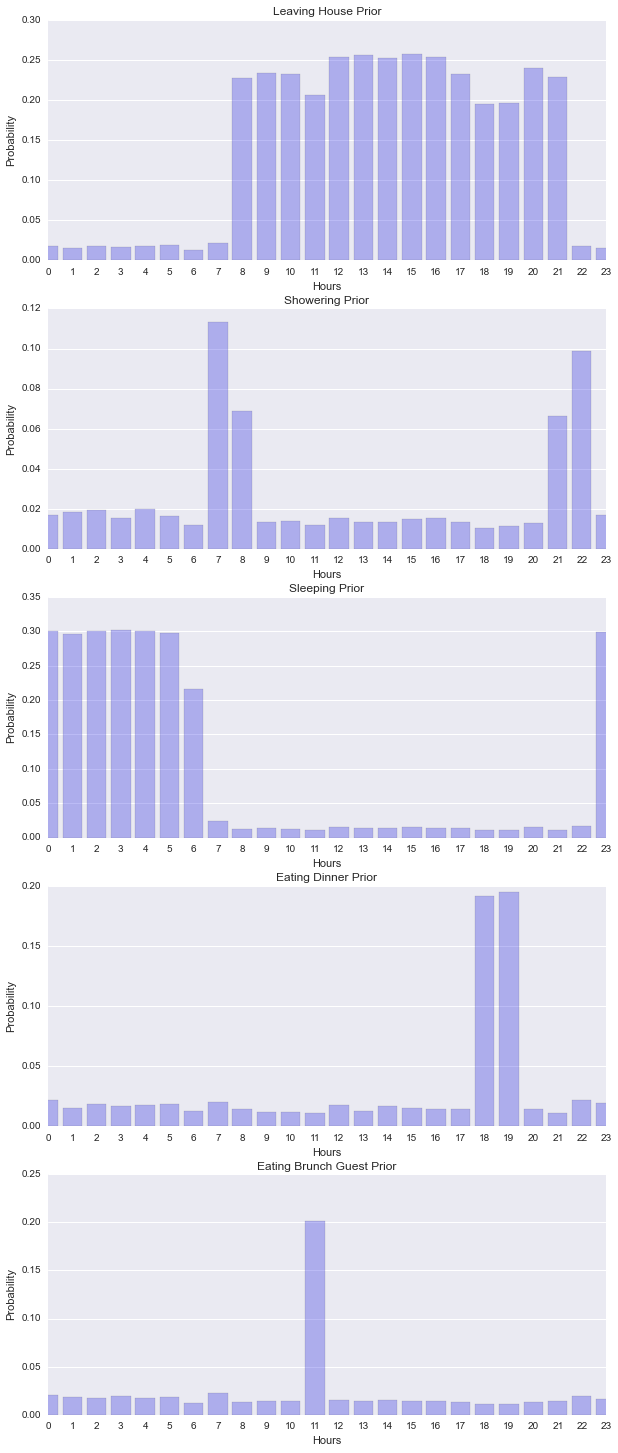

In [25]:
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
zero_start = first_time_dict[0]
# leaving
#print ax[0]
day_leaving = priorB[:,0][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_leaving = np.mean(day_leaving,axis=1)
#day_hourly_leaving = np.roll(day_hourly_leaving,0)
sns.barplot(day1,day_hourly_leaving,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Leaving House Prior')

#take shower
day_showering = priorB[:,2][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
#day_hourly_showering = np.roll(day_hourly_showering,2)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorB[:,5][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
#day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_eat_dinner = priorB[:,12][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat_dinner = np.mean(day_eat_dinner,axis=1)
#day_hourly_prepare_breakfast = np.roll(day_hourly_prepare_breakfast,2)
sns.barplot(day1,day_hourly_eat_dinner,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Eating Dinner Prior')

day_eat_brunch = priorB[:,13][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat_brunch = np.mean(day_eat_brunch,axis=1)
#day_hourly_guest = np.roll(day_hourly_guest,2)
sns.barplot(day1,day_hourly_eat_brunch,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Eating Brunch Guest Prior')


# Prior C

In [26]:
#read in data, choose a house and a X matrix type
act_df,sensor_df,X,Y = read_data('C', 'r')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
print start,end
i2m = {}
for i in range(len(all_act)):
    i2m[i] = set(list(act_df[act_df['label']==i2a[i]]['meaning']))

1227134866 1228724146


In [27]:
i2m

{0: {'leave house'},
 1: {'Eating'},
 2: {'use toilet downstairs'},
 3: {'take shower'},
 4: {'brush teeth'},
 5: {'use toilet upstairs'},
 6: {'shave'},
 7: {'go to bed'},
 8: {'get dressed'},
 9: {'take medication'},
 10: {'prepare Breakfast'},
 11: {'prepare Lunch'},
 12: {'prepare Dinner'},
 13: {'get snack'},
 14: {'get drink'},
 15: {'put clothes in washingmachine'},
 16: {'relax'},
 17: set()}

In [28]:
# Prior C
num_t = len(X)
num_act = len(all_act)
print num_act
HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1
LIKELY = 2
HIGHLY_LIKELY = 3
VERY_LIKELY = 4 
ALMOST_CERTAINLY = 8
# six_am of starting date of house A at Amsterdam
#first_zero_am = 1203894000
first_six_am = 1227157200
first_time_dict = {}
# {0: 12, 1: 72, 2: 132, 3: 192, 4: 252, 5: 312, 6: 372, 7: 432, 8: 492, 9: 552, 10: 612, 11: 672, 
#  12: 732, 13: 792, 14: 852, 15: 912, 16: 972, 17: 1032, 18: 1092, 19: 1152, 20: 1212, 21: 1272, 22: 1332, 23: 1392}

for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
    elif first_time_dict[i] > 60*24:
        first_time_dict[i] -= 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}
print first_time_dict
priorC = np.zeros([num_t,num_act])
for i in range(priorC.shape[0]):
    priorC[i] = np.random.uniform(size=num_act)
random_priorC = priorC.copy()
#print priorC[0]
#print priorA[0]
# add some prior to it
# leaving the house should be uniform between 8:00am to 10:00pm, and basically 0 between 10:00pm to 8:00am
first_leaving = (first_six_am + 2 * HOUR * MINUTE - start)/MINUTE
#print first_leaving
end_leaving = first_leaving + HOUR * (22-8)

# # {0: {'leave house'},
#  1: {'Eating'},
#  2: {'use toilet downstairs'},
#  3: {'take shower'},
#  4: {'brush teeth'},
#  5: {'use toilet upstairs'},
#  6: {'shave'},
#  7: {'go to bed'},
#  8: {'get dressed'},
#  9: {'take medication'},
#  10: {'prepare Breakfast'},
#  11: {'prepare Lunch'},
#  12: {'prepare Dinner'},
#  13: {'get snack'},
#  14: {'get drink'},
#  15: {'put clothes in washingmachine'},
#  16: {'relax'},
#  17: set()}
# #
# {0: 12, 1: 72, 2: 132, 3: 192, 4: 252, 5: 312, 6: 372, 7: 432, 8: 492, 9: 552, 10: 612, 11: 672, 
#  12: 732, 13: 792, 14: 852, 15: 912, 16: 972, 17: 1032, 18: 1092, 19: 1152, 20: 1212, 21: 1272, 22: 1332, 23: 1392}
for i in range(num_t):
    
    # leave house 0
    if i%DAY < first_time_dict[22] and i%DAY > first_time_dict[8]:
        priorC[i][0] += 15
    # eating should between 7-9am 11-13 18-20
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[9]) or (i%DAY > first_time_dict[11] and i%DAY < first_time_dict[13]) or (i%DAY > first_time_dict[18] and i%DAY < first_time_dict[20]):
        priorC[i][1] += LESS_LIKELY
    
    # Use Toilet downstairs should be uniformly distributed around 8am to 10pm 2:
    if i%DAY > first_time_dict[8] or i%DAY<first_time_dict[22]:
        priorC[i][2] += LESS_LIKELY
        
    # Take Shower should be around 6-8am and 21-23 3
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[9]) or (i%DAY > first_time_dict[21] and i%DAY < first_time_dict[23]):
        priorC[i][3] += LIKELY
        
    # brush teeth between 6 and 7, 22 and 23 4
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[7]) or (i%DAY > first_time_dict[22] and i%DAY < first_time_dict[23]):
        priorC[i][4] += HIGHLY_LIKELY
        
    # Use toilet upstairs always happen at night 20 - 7 5
    if i%DAY > first_time_dict[22] or i%DAY < first_time_dict[7]:
        priorC[i][5] += LIKELY
    
    # Shave should be in the morning around 6-8
    if i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]:
        priorC[i][6] += HIGHLY_LIKELY
        
    # Sleep should be 23 - 7 7
    if i%DAY > first_time_dict[23] or i%DAY < first_time_dict[7]:
        priorC[i][7] += ALMOST_CERTAINLY
    
    # get dressed should be around 7-9 am 8
    if i%DAY > first_time_dict[7] and i%DAY < first_time_dict[9]:
        priorC[i][8] += HIGHLY_LIKELY
    
    # take medication should happen uniformly between 8-23 9 
    if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[23]:
        priorC[i][9] += LESS_LIKELY
    
    # prepare breakfast should be in 7-8 am: 10
    if i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]:
        priorC[i][10] += HIGHLY_LIKELY
    
    
    #  11: {'prepare Lunch'} 11 - 12
    if i%DAY > first_time_dict[11] and i%DAY < first_time_dict[12]:
        priorC[i][11] += HIGHLY_LIKELY
    
    #  12: {'prepare Dinner'} 17-19
    if i%DAY > first_time_dict[17] and i%DAY < first_time_dict[19]:
        priorC[i][12] += HIGHLY_LIKELY
    
    #  13: {'get snack'}, 8-20
#     if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[20]:
#         priorC[i][13] += LESS_LIKELY
        
    #  14: {'get drink'}, 8-23
    if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[23]:
        priorC[i][14] += LESS_LIKELY
    
    #15: {'put clothes in washingmachine'}, 8 - 20
    if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[20]:
        priorC[i][15] += LESS_LIKELY
    
    #  16: {'relax'}, 8-23
    if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[20]:
        priorC[i][16] += ALMOST_CERTAINLY    
    
    # Unknown state
    if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[23]:
        priorC[i][17] += LIKELY
        
 
    priorC[i]/=np.sum(priorC[i])

#print np.max(priorC[0])

18
{0: 12, 1: 72, 2: 132, 3: 192, 4: 252, 5: 312, 6: 372, 7: 432, 8: 492, 9: 552, 10: 612, 11: 672, 12: 732, 13: 792, 14: 852, 15: 912, 16: 972, 17: 1032, 18: 1092, 19: 1152, 20: 1212, 21: 1272, 22: 1332, 23: 1392}


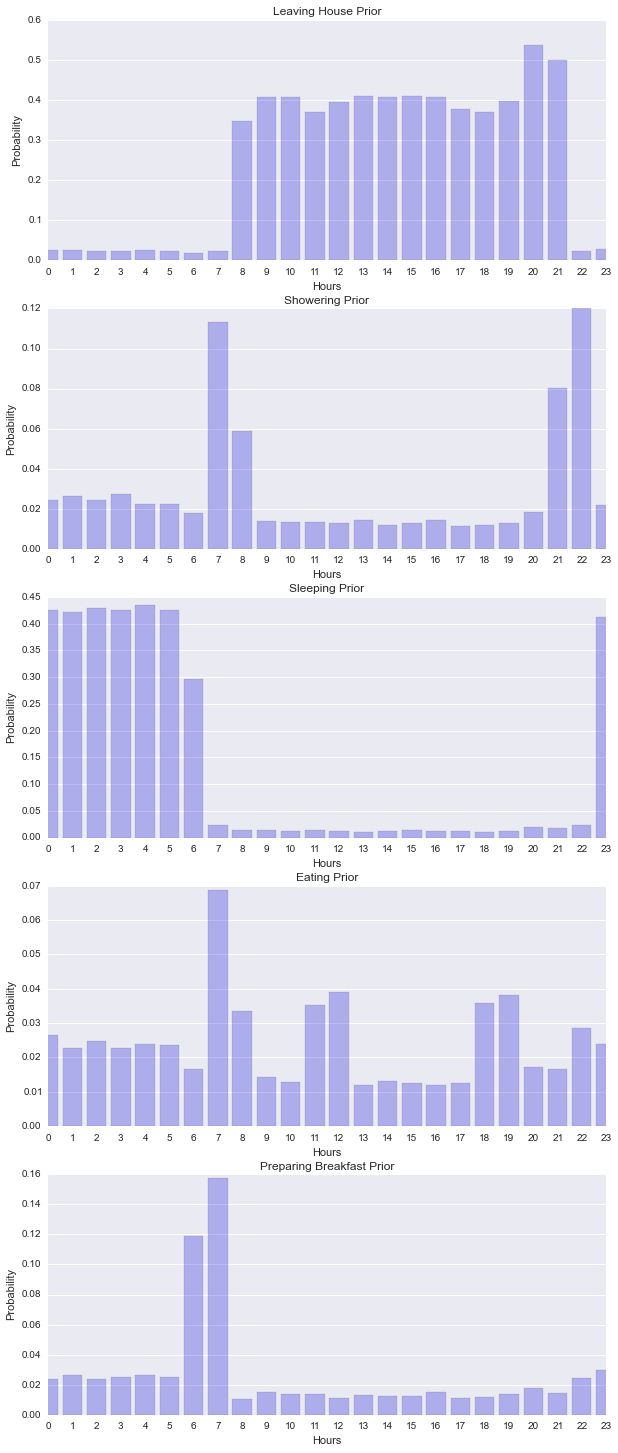

In [29]:

# # {0: {'leave house'},
#  1: {'Eating'},
#  2: {'use toilet downstairs'},
#  3: {'take shower'},
#  4: {'brush teeth'},
#  5: {'use toilet upstairs'},
#  6: {'shave'},
#  7: {'go to bed'},
#  8: {'get dressed'},
#  9: {'take medication'},
#  10: {'prepare Breakfast'},
#  11: {'prepare Lunch'},
#  12: {'prepare Dinner'},
#  13: {'get snack'},
#  14: {'get drink'},
#  15: {'put clothes in washingmachine'},
#  16: {'relax'},
#  17: set()}
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
zero_start = first_time_dict[0]
# leaving
#print ax[0]
day_leaving = priorC[:,0][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_leaving = np.mean(day_leaving,axis=1)
#day_hourly_leaving = np.roll(day_hourly_leaving,0)
sns.barplot(day1,day_hourly_leaving,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Leaving House Prior')

#take shower
day_showering = priorC[:,3][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
#day_hourly_showering = np.roll(day_hourly_showering,2)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorC[:,7][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
#day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_eat = priorC[:,1][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat = np.mean(day_eat,axis=1)
#day_hourly_prepare_breakfast = np.roll(day_hourly_prepare_breakfast,2)
sns.barplot(day1,day_hourly_eat,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Eating Prior')

day_prepare_breakfast = priorC[:,10][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_prepare_breakfast = np.mean(day_prepare_breakfast,axis=1)
#day_hourly_guest = np.roll(day_hourly_guest,2)
sns.barplot(day1,day_hourly_prepare_breakfast,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Preparing Breakfast Prior')


In [32]:
np.save('Prior_A.npy',priorA)
np.save('Prior_B.npy',priorB)
np.save('Prior_C.npy',priorC)

In [33]:
pwd

u'/Users/yuhantang/AM207Project/correct_version/am207finalproject/data'

# IGNORE THE REST, WRONG

# ChangePrior

{0: {'leave house'},
 1: {'Eating'},
 2: {'use toilet'},
 3: {'take shower'},
 4: {'brush teeth'},
 5: {'go to bed'},
 6: {'prepare Breakfast'},
 7: {'prepare Dinner'},
 8: {'get snack'},
 9: {'get drink'},
 10: {'put items in dishwasher'},
 11: {'unload dishwasher'},
 12: {'store groceries'},
 13: {'put clothes in washingmachine'},
 14: {'unload washingmachine'},
 15: {'receive guest'},
 16: set()}

In [ ]:
act_df,sensor_df,X,Y = read_data('A', 'c')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))

timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start


In [ ]:
num_t = len(X)
num_act = len(all_act)

HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1
LIKELY = 2
HIGHLY_LIKELY = 3
VERY_LIKELY = 4 
ALMOST_CERTAINLY = 8
# six_am of starting date of house A at Amsterdam
first_zero_am = 1203894000
first_six_am = 1203915600
first_time_dict = {}
for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
priorA = np.zeros([num_t,num_act+1])
for i in range(priorA.shape[0]):
    priorA[i] = np.random.uniform(size=num_act+1)
random_priorA = priorA.copy()
print priorA[0]
#print priorA[0]
# add some prior to it
# leaving the house should be uniform between 8:00am to 10:00pm, and basically 0 between 10:00pm to 8:00am
first_leaving = (first_six_am + 2 * HOUR * MINUTE - start)/MINUTE
#print first_leaving
end_leaving = first_leaving + HOUR * (22-8)

# {0: {'leave house'},
#  1: {'Eating'},
#  2: {'use toilet'},
#  3: {'take shower'},
#  4: {'brush teeth'},
#  5: {'go to bed'},
#  6: {'prepare Breakfast'},
#  7: {'prepare Dinner'},
#  8: {'get snack'},
#  9: {'get drink'},
#  10: {'put items in dishwasher'},
#  11: {'unload dishwasher'},
#  12: {'store groceries'},
#  13: {'put clothes in washingmachine'},
#  14: {'unload washingmachine'},
#  15: {'receive guest'},
#  16: set()}

# {0: 1360, 1: 1420, 2: 40, 3: 100, 4: 160, 5: 220, 6: 280, 7: 340, 8: 400, 9: 460, 10: 520, 11: 580, 
#  12: 640, 13: 700, 14: 760, 15: 820, 16: 880, 17: 940, 18: 1000, 19: 1060, 20: 1120, 21: 1180, 22: 1240, 23: 1300}
for i in range(num_t):
    
    # leave house
    if (i%DAY < first_time_dict[20] and i%DAY > first_time_dict[6]) or (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[8]):
        priorA[i][0] += ALMOST_CERTAINLY
        
    # eating 6-9 am 12 -13 pm 18-19
    #if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]) or (i%DAY > first_time_dict[12] and i%DAY < first_time_dict[13]) or (i%DAY > first_time_dict[18] and i%DAY < first_time_dict[19]):
    priorA[i][1] = 0

    # use toilet should be uniform 2
    
    # Take shower should be within 6-8am and 21-23 3
    
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]) or (i%DAY > first_time_dict[21] and i%DAY < first_time_dict[23]):
        priorA[i][3] += ALMOST_CERTAINLY
    
    # brush teath is so short to modify 4
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[8]) or (i%DAY > first_time_dict[22] and i%DAY < first_time_dict[23]):
        priorA[i][4] += ALMOST_CERTAINLY
    
    
    # go to bed should between 11:00pm to 7:00 am 5
    if (i%DAY > first_time_dict[22] and i%DAY < first_time_dict[1]) or (i%DAY < first_time_dict[8] and i%DAY > first_time_dict[6]):
        priorA[i][5] += ALMOST_CERTAINLY
    
    # prepare Breakfast must be within 6-8am 6 
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[9]):
        priorA[i][6] += ALMOST_CERTAINLY
    
    # prepare Dinner must be within 5-7 pm 7
    if (i%DAY > first_time_dict[17] and i%DAY < first_time_dict[19]):
        priorA[i][7] += ALMOST_CERTAINLY
    
    # get snack is almost uniformly distributed within day time 8am-10pm 8
#     if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[22]):
#         priorA[i][8] += ALMOST_CERTAINLY
    
    # get drink is identical to get snack 9
#     if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[22]):
#         priorA[i][9] += ALMOST_CERTAINLY
        
    # 'put items in dishwasher' randomly among all day.10
    #if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[20]):
        #priorA[i][10] += LESS_LIKELY
    
    # unload dishwasher randomly from 10 am to 8 pm11
#     if (i%DAY > first_time_dict[10] and i%DAY < first_time_dict[20]):
#         priorA[i][11] += ALMOST_CERTAINLY
        
    # store greceries, randomly among all day from 10 am to 7pm 12
#     if (i%DAY > first_time_dict[10] and i%DAY < first_time_dict[19]):
#         priorA[i][12] += ALMOST_CERTAINLY
    
    # put clothes in washingmachine key no change 13 no change
    # unload washingmachine no change
    # receive guest randomly between 10 am to 5 pm: change15
    
    if (i%DAY > first_time_dict[10] and i%DAY < first_time_dict[17]):
        priorA[i][15] += ALMOST_CERTAINLY
    
    # Unknown state 16, almost certainly from 8am - 10pm:
    
    if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[23]):
        priorA[i][16] += ALMOST_CERTAINLY
        
    priorA[i]/=np.sum(priorA[i])
# Eating should be around 6-9 am, 12 - 1 pm, and 6-7 pm

# for i in range(num_t):
#     if i%DAY > first_time_dict[6] and i%DAY < first_time_dict[9] 
#     \ or i%DAY > first_time_dict[12] and i%DAY < first_time_dict[13] 
#     \ or i%DAY > first_time_dict[18] and i%DAY < first_time_dict[19]:
#         priorA[i][1] += 2


In [ ]:
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
# Eating
#print ax[0]
day_eating = priorA[:,1][:MINUTE * 24].reshape(24,60)
day_hourly_eating = np.mean(day_eating,axis=1)
day_hourly_eating = np.roll(day_hourly_eating,2)
sns.barplot(day1,day_hourly_eating,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Eating Prior')

#take shower
day_showering = priorA[:,3][:MINUTE * 24].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
day_hourly_showering = np.roll(day_hourly_showering,2)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorA[:,5][:MINUTE * 24].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_prepare_breakfast = priorA[:,6][:MINUTE * 24].reshape(24,60)
day_hourly_prepare_breakfast = np.mean(day_prepare_breakfast,axis=1)
day_hourly_prepare_breakfast = np.roll(day_hourly_prepare_breakfast,2)
sns.barplot(day1,day_hourly_prepare_breakfast,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Preparing Breakfast Prior')

day_guest = priorA[:,15][:MINUTE * 24].reshape(24,60)
day_hourly_guest = np.mean(day_guest,axis=1)
day_hourly_guest = np.roll(day_hourly_guest,2)
sns.barplot(day1,day_hourly_guest,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Receiving Guest Prior')


In [ ]:
np.save('C_Prior_A',priorA)

In [ ]:
pwd

# Prior B

In [ ]:
#read in data, choose a house and a X matrix type
act_df,sensor_df,X,Y = read_data('B', 'c')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
print start,end
i2m = {}
for i in range(len(all_act)):
    i2m[i] = set(list(act_df[act_df['label']==i2a[i]]['meaning']))

In [ ]:
i2m

In [ ]:
# Prior
num_t = len(X)
num_act = len(all_act)
HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1
LIKELY = 2
HIGHLY_LIKELY = 3
VERY_LIKELY = 4 
ALMOST_CERTAINLY = 8
# six_am of starting date of house A at Amsterdam
#first_zero_am = 1203894000
first_six_am = 1248235200
first_time_dict = {}
#{0: 509, 1: 569, 2: 629, 3: 689, 4: 749, 5: 809, 6: 869, 7: 929, 8: 989, 9: 1049, 10: 1109, 11: 1169, 
#12: 1229, 13: 1289, 14: 1349, 15: 1409, 16: 29, 17: 89, 18: 149, 19: 209, 20: 269, 21: 329, 22: 389, 23: 449}

for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
    elif first_time_dict[i] > 60*24:
        first_time_dict[i] -= 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}
#print first_time_dict
priorB = np.zeros([num_t,num_act])
for i in range(priorB.shape[0]):
    priorB[i] = np.random.uniform(size=num_act)
random_priorB = priorB.copy()
#print priorB[0]
#print priorA[0]
# add some prior to it
# leaving the house should be uniform between 8:00am to 10:00pm, and basically 0 between 10:00pm to 8:00am
first_leaving = (first_six_am + 2 * HOUR * MINUTE - start)/MINUTE
#print first_leaving
end_leaving = first_leaving + HOUR * (22-8)

# {0: {'Leaving the house'},
#  1: {'Use toilet'},
#  2: {'Take shower'},
#  3: {'Brush teeth'},
#  4: {'Shaving'},
#  5: {'Go to bed'},
#  6: {'Get dressed'},
#  7: {'Prepare brunch'},
#  8: {'Prepare dinner'},
#  9: {'Get a drink'},
#  10: {'Wash dishes'},
#  11: {'Answering phone'},
#  12: {'Eat dinner'},
#  13: {'Eat brunch'},
#  14: {'Setting up sensors'},
#  15: {'Unpacking'},
#  16: {'Install sensor'},
#  17: {'On phone'},
#  18: {'Fasten kitchen camera'},
#  19: {'Wash toaster'},
#  20: {'Play piano'},
#  21: {'Gwenn searches keys'},
#  22: {'Prepare for leaving'},
#  23: {'Drop dish (No dishwash)'},
#  24: set()}
#{0: 509, 1: 569, 2: 629, 3: 689, 4: 749, 5: 809, 6: 869, 7: 929, 8: 989, 9: 1049, 10: 1109, 11: 1169, 
#12: 1229, 13: 1289, 14: 1349, 15: 1409, 16: 29, 17: 89, 18: 149, 19: 209, 20: 269, 21: 329, 22: 389, 23: 449}

for i in range(num_t):
    
    # leave house 0
    if (i%DAY < first_time_dict[20] and i%DAY > first_time_dict[18]) or (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[9]):
        priorB[i][0] += ALMOST_CERTAINLY
    
#     # Use Toilet should be uniformly distributed around 8am to 10pm 1:
#     if i%DAY > first_time_dict[8] or i%DAY<first_time_dict[22]:
#         priorB[i][1] += LESS_LIKELY
        
    # Take Shower should be around 6-8am and 21-23 2
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[9]):
        priorB[i][2] += ALMOST_CERTAINLY
        
    # brush teeth between 6 and 7, 22 and 23 3
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[8]) or (i%DAY > first_time_dict[22] and i%DAY < first_time_dict[23]):
        priorB[i][3] += ALMOST_CERTAINLY
        
    # Shaving should between 7-8 4
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[7]):
        priorB[i][4] += ALMOST_CERTAINLY
        
    # Sleep should between 11pm to 7am 5
    if (i%DAY > first_time_dict[23] and i%DAY < first_time_dict[1]) or (i%DAY < first_time_dict[8] and i%DAY > first_time_dict[6]):
        priorB[i][5] += ALMOST_CERTAINLY
    
    # get dressed should between 8-9 am 6
    if (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[9]) or (i%DAY > first_time_dict[22] and i%DAY < first_time_dict[23]):
        priorB[i][6] += ALMOST_CERTAINLY
    
    # Prepare Brunch 9-11 7
    if i%DAY > first_time_dict[9] and i%DAY < first_time_dict[11]:
        priorB[i][7] += ALMOST_CERTAINLY
    
    # Prepare Dinner 17 -18 8
    if i%DAY > first_time_dict[17] and i%DAY < first_time_dict[18]:
        priorB[i][8] += ALMOST_CERTAINLY
    
#     # get a drink should between 9 - 22 9
#     if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
#         priorB[i][9] += LESS_LIKELY
        
#     # wash dish should be uniform betwwen 9-22 10
    if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
         priorB[i][10] += LESS_LIKELY
        
#     # Answering Phone should be uniform around 9-22 11
#     if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
#         priorB[i][11] += LESS_LIKELY
        
    # Eat Dinner should be around 18 -20 12
    if i%DAY > first_time_dict[18] and i%DAY < first_time_dict[19]:
        priorB[i][12] += ALMOST_CERTAINLY
    
    # eat Brunch should be around 11-12 13
    if i%DAY > first_time_dict[11] and i%DAY < first_time_dict[12]:
        priorB[i][13] += LESS_LIKELY
        
    # setting up sensor should not be modified 14
    # unpacking should not be modified 15
    # install sensor should not be modified 16
    # on phone should be the same as answering phone 17
#     if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
#         priorB[i][17] += LESS_LIKELY
        
    # Fasten kitchen camera should not be modified 18
    # wash toatser not modified 19
    # play piano should be around 18 - 22 20
#     if i%DAY > first_time_dict[18] and i%DAY < first_time_dict[22]:
#         priorB[i][20] += LIKELY
    
    # searches key not modified 21
    # prepare for leaving should be around 8 - 9 22
#     if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[9]:
#         priorB[i][22] += HIGHLY_LIKELY
    
    
    # drop dish no midification 23
    priorB[i][23] = 1e-5
    # Unknown state 
    if i%DAY > first_time_dict[9] or i%DAY < first_time_dict[22]:
        priorB[i][24] += ALMOST_CERTAINLY
    priorB[i]/=np.sum(priorB[i])

print np.max(priorB[0])

In [ ]:
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
zero_start = first_time_dict[0]
# leaving
#print ax[0]
day_leaving = priorB[:,0][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_leaving = np.mean(day_leaving,axis=1)
#day_hourly_leaving = np.roll(day_hourly_leaving,0)
sns.barplot(day1,day_hourly_leaving,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Leaving House Prior')

#take shower
day_showering = priorB[:,2][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
#day_hourly_showering = np.roll(day_hourly_showering,2)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorB[:,5][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
#day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_eat_dinner = priorB[:,12][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat_dinner = np.mean(day_eat_dinner,axis=1)
#day_hourly_prepare_breakfast = np.roll(day_hourly_prepare_breakfast,2)
sns.barplot(day1,day_hourly_eat_dinner,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Eating Dinner Prior')

day_eat_brunch = priorB[:,13][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat_brunch = np.mean(day_eat_brunch,axis=1)
#day_hourly_guest = np.roll(day_hourly_guest,2)
sns.barplot(day1,day_hourly_eat_brunch,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Eating Brunch Guest Prior')


In [ ]:
np.save('C_Prior_B',priorB)

In [ ]:
#read in data, choose a house and a X matrix type
act_df,sensor_df,X,Y = read_data('C', 'c')
#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
print start,end
i2m = {}
for i in range(len(all_act)):
    i2m[i] = set(list(act_df[act_df['label']==i2a[i]]['meaning']))

In [ ]:
i2m

In [ ]:
# Prior C
num_t = len(X)
num_act = len(all_act)
print num_act
HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1
LIKELY = 2
HIGHLY_LIKELY = 3
VERY_LIKELY = 4 
ALMOST_CERTAINLY = 8
# six_am of starting date of house A at Amsterdam
#first_zero_am = 1203894000
first_six_am = 1227157200
first_time_dict = {}
# {0: 12, 1: 72, 2: 132, 3: 192, 4: 252, 5: 312, 6: 372, 7: 432, 8: 492, 9: 552, 10: 612, 11: 672, 
#  12: 732, 13: 792, 14: 852, 15: 912, 16: 972, 17: 1032, 18: 1092, 19: 1152, 20: 1212, 21: 1272, 22: 1332, 23: 1392}

for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
    elif first_time_dict[i] > 60*24:
        first_time_dict[i] -= 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}
print first_time_dict
priorC = np.zeros([num_t,num_act])
for i in range(priorC.shape[0]):
    priorC[i] = np.random.uniform(size=num_act)
random_priorC = priorC.copy()
#print priorC[0]
#print priorA[0]
# add some prior to it
# leaving the house should be uniform between 8:00am to 10:00pm, and basically 0 between 10:00pm to 8:00am
first_leaving = (first_six_am + 2 * HOUR * MINUTE - start)/MINUTE
#print first_leaving
end_leaving = first_leaving + HOUR * (22-8)

# # {0: {'leave house'},
#  1: {'Eating'},
#  2: {'use toilet downstairs'},
#  3: {'take shower'},
#  4: {'brush teeth'},
#  5: {'use toilet upstairs'},
#  6: {'shave'},
#  7: {'go to bed'},
#  8: {'get dressed'},
#  9: {'take medication'},
#  10: {'prepare Breakfast'},
#  11: {'prepare Lunch'},
#  12: {'prepare Dinner'},
#  13: {'get snack'},
#  14: {'get drink'},
#  15: {'put clothes in washingmachine'},
#  16: {'relax'},
#  17: set()}
# #
# {0: 12, 1: 72, 2: 132, 3: 192, 4: 252, 5: 312, 6: 372, 7: 432, 8: 492, 9: 552, 10: 612, 11: 672, 
#  12: 732, 13: 792, 14: 852, 15: 912, 16: 972, 17: 1032, 18: 1092, 19: 1152, 20: 1212, 21: 1272, 22: 1332, 23: 1392}
for i in range(num_t):
    
    # leave house 0
    if (i%DAY < first_time_dict[20] and i%DAY > first_time_dict[18]) or (i%DAY > first_time_dict[8] and i%DAY < first_time_dict[10]):
        priorC[i][0] += ALMOST_CERTAINLY
    # eating should between 7-9am 11-13 18-20
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[9]) or (i%DAY > first_time_dict[11] and i%DAY < first_time_dict[13]) or (i%DAY > first_time_dict[18] and i%DAY < first_time_dict[20]):
        priorC[i][1] += NOT_LIKELY
    
#     # Use Toilet downstairs should be uniformly distributed around 8am to 10pm 2:
#     if i%DAY > first_time_dict[8] or i%DAY<first_time_dict[22]:
#         priorC[i][2] += LESS_LIKELY
        
    # Take Shower should be around 6-8am and 21-23 3
    if (i%DAY > first_time_dict[7] and i%DAY < first_time_dict[8]) or (i%DAY > first_time_dict[21] and i%DAY < first_time_dict[23]):
        priorC[i][3] += LESS_LIKELY
        
    # brush teeth between 6 and 7, 22 and 23 4
    if (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[7]) or (i%DAY > first_time_dict[22] and i%DAY < first_time_dict[23]):
        priorC[i][4] += ALMOST_CERTAINLY
        
#     # Use toilet upstairs always happen at night 20 - 7 5
#     if i%DAY > first_time_dict[22] or i%DAY < first_time_dict[7]:
#         priorC[i][5] += LIKELY
    
    # Shave should be in the morning around 6-8
    if i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]:
        priorC[i][6] += ALMOST_CERTAINLY
        
    # Sleep should be 23 - 7 7
    if i%DAY > first_time_dict[22] or (i%DAY > first_time_dict[6] and i%DAY < first_time_dict[8]):
        priorC[i][7] += ALMOST_CERTAINLY
    
    # get dressed should be around 7-9 am 8
    if i%DAY > first_time_dict[7] and i%DAY < first_time_dict[9]:
        priorC[i][8] += ALMOST_CERTAINLY
    
#     # take medication should happen uniformly between 8-23 9 
#     if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[23]:
#         priorC[i][9] += HIGHLY_LIKELY
    
    # prepare breakfast should be in 7-8 am: 10
    if i%DAY > first_time_dict[7] and i%DAY < first_time_dict[8]:
        priorC[i][10] += ALMOST_CERTAINLY
    
    
    #  11: {'prepare Lunch'} 11 - 12
    if i%DAY > first_time_dict[11] and i%DAY < first_time_dict[12]:
        priorC[i][11] += ALMOST_CERTAINLY
    
    #  12: {'prepare Dinner'} 17-19
    if i%DAY > first_time_dict[17] and i%DAY < first_time_dict[19]:
        priorC[i][12] += LESS_LIKELY
    
#     #  13: {'get snack'}, 8-20
#     if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[20]:
#         priorC[i][13] += ALMOST_CERTAINLY
        
#     #  14: {'get drink'}, 8-23
#     if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[23]:
#         priorC[i][14] += LESS_LIKELY
    
#     #15: {'put clothes in washingmachine'}, 8 - 20
#     if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[20]:
#         priorC[i][15] += LESS_LIKELY
    
#     #  16: {'relax'}, 8-23
#     if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[20]:
#         priorC[i][16] += HIGHLY_LIKELY    
    
    # Unknown state
#     if i%DAY > first_time_dict[8] and i%DAY < first_time_dict[23]:
#         priorC[i][17] += ALMOST_CERTAINLY
        
 
    priorC[i]/=np.sum(priorC[i])

#print np.max(priorC[0])

In [ ]:

# # {0: {'leave house'},
#  1: {'Eating'},
#  2: {'use toilet downstairs'},
#  3: {'take shower'},
#  4: {'brush teeth'},
#  5: {'use toilet upstairs'},
#  6: {'shave'},
#  7: {'go to bed'},
#  8: {'get dressed'},
#  9: {'take medication'},
#  10: {'prepare Breakfast'},
#  11: {'prepare Lunch'},
#  12: {'prepare Dinner'},
#  13: {'get snack'},
#  14: {'get drink'},
#  15: {'put clothes in washingmachine'},
#  16: {'relax'},
#  17: set()}
day1 = np.arange(24)
fig, ax = plt.subplots(5,1,figsize = (10,25))
zero_start = first_time_dict[0]
# leaving
#print ax[0]
day_leaving = priorC[:,0][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_leaving = np.mean(day_leaving,axis=1)
#day_hourly_leaving = np.roll(day_hourly_leaving,0)
sns.barplot(day1,day_hourly_leaving,color="b",alpha = 0.3,ax=ax[0])
ax[0].set_xticks(np.arange(0,24,1))
ax[0].set_xlim(0,23)
ax[0].set_xlabel('Hours')
ax[0].set_ylabel('Probability')
ax[0].set_title('Leaving House Prior')

#take shower
day_showering = priorC[:,3][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_showering = np.mean(day_showering,axis=1)
#day_hourly_showering = np.roll(day_hourly_showering,2)
sns.barplot(day1,day_hourly_showering,color="b",alpha = 0.3,ax = ax[1])
ax[1].set_xticks(np.arange(0,24,1))
ax[1].set_xlim(0,23)
ax[1].set_xlabel('Hours')
ax[1].set_ylabel('Probability')
ax[1].set_title('Showering Prior')

day_bed = priorC[:,7][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
#day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3,ax = ax[2])
ax[2].set_xticks(np.arange(0,24,1))
ax[2].set_xlim(0,23)
ax[2].set_xlabel('Hours')
ax[2].set_ylabel('Probability')
ax[2].set_title('Sleeping Prior')

day_eat = priorC[:,1][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_eat = np.mean(day_eat,axis=1)
#day_hourly_prepare_breakfast = np.roll(day_hourly_prepare_breakfast,2)
sns.barplot(day1,day_hourly_eat,color="b",alpha = 0.3,ax = ax[3])
ax[3].set_xticks(np.arange(0,24,1))
ax[3].set_xlim(0,23)
ax[3].set_xlabel('Hours')
ax[3].set_ylabel('Probability')
ax[3].set_title('Eating Prior')

day_prepare_breakfast = priorC[:,10][zero_start:zero_start+MINUTE * 24].reshape(24,60)
day_hourly_prepare_breakfast = np.mean(day_prepare_breakfast,axis=1)
#day_hourly_guest = np.roll(day_hourly_guest,2)
sns.barplot(day1,day_hourly_prepare_breakfast,color="b",alpha = 0.3,ax = ax[4])
ax[4].set_xticks(np.arange(0,24,1))
ax[4].set_xlim(0,23)
ax[4].set_xlabel('Hours')
ax[4].set_ylabel('Probability')
ax[4].set_title('Preparing Breakfast Prior')


In [ ]:
# np.save('C_Prior_A',priorA)
# np.save('C_Prior_B',priorB)
np.save('C_Prior_C',priorC)